In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt

import math

%matplotlib inline

In [2]:
# Define configs
configs = {
    "batch_size": 64,
    "test_batch_size": 1000,
    "epochs": 14,
    "lr": 1.0,
    "gamma": 0.7,
    "seed": 1,
    "no_cuda": False
}

use_cuda = not configs["no_cuda"] and torch.cuda.is_available()

torch.manual_seed(configs["seed"])

if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
train_kwargs = {"batch_size": configs["batch_size"]}
test_kwargs = {"batch_size": configs["test_batch_size"]}

if use_cuda:
    cuda_kwargs = {
        "num_workers": 1,
        "pin_memory": True,
        "shuffle": True
    }
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)
    
print(f"{device=}")
print(f"{train_kwargs=}")
print(f"{test_kwargs=}")

device=device(type='cuda')
train_kwargs={'batch_size': 64, 'num_workers': 1, 'pin_memory': True, 'shuffle': True}
test_kwargs={'batch_size': 1000, 'num_workers': 1, 'pin_memory': True, 'shuffle': True}


## Data loading

In [3]:
# Determining the mean and std of training image, expect a mean and a std only due to grayscale image (1 channel)
train_dataset = torchvision.datasets.MNIST("./data", train=True, download=True)

# divide 255 because in the first step of DataLoader, PIL will always convert image to [0, 1], we want to get the mean & std of the images which are in the range [0, 1] instead of [0, 255]
print("mean =", torch.mean(train_dataset.data.float() / 255).item())  
print("std =", torch.std(train_dataset.data.float() / 255).item())

mean = 0.13066047430038452
std = 0.30810782313346863


In [4]:
# Data transformation
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

# Dataset
train_dataset = torchvision.datasets.MNIST("./data", train=True, download=True, transform=transform) # transform is not applied here yet
test_dataset = torchvision.datasets.MNIST("./data", train=False, download=True, transform=transform)

# Data loader
# What DataLoader do:
# 1. Convert raw image to PIL image (add one channel dimension, convert pixels to range [0, 1]) (automatically)
# 2. Do what we specify in transform (ToTensor(), Normalize())
train_loader = torch.utils.data.DataLoader(train_dataset, **train_kwargs) # transform is applied here
test_loader = torch.utils.data.DataLoader(test_dataset, **test_kwargs)

## Define network

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        self.relu2 = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(p=0.25)
        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(in_features=9216, out_features=128)
        self.relu3 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=128, out_features=10)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool(x)
        x = self.dropout1(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = self.softmax(x)
        return output

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        probs = model(data)
        log_probs = torch.log(probs)
        loss = F.nll_loss(log_probs, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            probs = model(data)
            log_probs = torch.log(probs)
            test_loss += F.nll_loss(log_probs, target, reduction="sum").item()
            pred = probs.argmax(dim=1, keepdim=True) 
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Shape after conv or pool:
$$n_{out} = \lfloor \frac{n_{in} + 2p - f}{s} \rfloor + 1$$

```
x = self.conv1(x) ---------------------- (B, 1, 28, 28) -> (B, 32, 26, 26)
x = self.relu1(x) 
x = self.conv2(x) ---------------------- (B, 32, 26, 26) -> (B, 64, 24, 24)
x = self.relu2(x)
x = self.maxpool(x) -------------------- (B, 64, 24, 24) -> (B, 64, 12, 12)
x = self.dropout1(x)
x = self.flatten(x) -------------------- (B, 64, 12, 12) -> (B, 64*12*12) = (B, 9216)
x = self.fc1(x) ------------------------ (B, 9216) -> (B, 128)
x = self.relu3(x)
x = self.dropout2(x)
x = self.fc2(x) ------------------------ (B, 128) -> (B, 10)
output = self.softmax(x)
```

In [6]:
model = Net().to(device)
optimizer = torch.optim.Adadelta(model.parameters(), lr=configs["lr"])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=configs["gamma"])

In [7]:
model

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (relu3): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [91]:
epochs = 5
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.324211
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.134280
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.150293
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.109422
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.155825
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.049987
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.048612
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.184858
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.106054
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.150060

Test set: Average loss: 0.0565, Accuracy: 9820/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.078666
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.015847
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.031117
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.071596
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.089531
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.222768
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.085436
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.017501
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.094770
T

## Define forward & backward hooks

Visualization
- Activations of each and every layer
- Gradients of each and every layer
- Weights of each and every layer (if exists)
- Biases of each and every layer (if exists)

Input -> conv -> relu -> conv -> relu -> max_pool -> dropout -> fc -> relu -> dropout -> fc -> softmax

In [92]:
train_iter = iter(train_loader)
test_iter = iter(test_loader)

sample_batch = next(train_iter)
sample_input = sample_batch[0][0:1]
sample_target = sample_batch[1][0:1]

print(f"{sample_input.shape=}")
print(f"{sample_target=}")

sample_input.shape=torch.Size([1, 1, 28, 28])
sample_target=tensor([3])


In [93]:
def forward_hook(layer_name):
    def _forward_hook(module, inp, out):
        print(f"Forward: {layer_name}")
        tracked[layer_name]["a"] = out.detach().cpu().numpy()
        
        if len(list(module.parameters())) > 0: # Layer consists of parameters
            tracked[layer_name]["w"] = module.weight.data.detach().cpu().numpy()
            tracked[layer_name]["b"] = module.bias.data.detach().cpu().numpy()
            
    return _forward_hook

def backward_hook(layer_name):
    def _backward_hook(module, grad_inp, grad_out):
        print(f"Backward: {layer_name}")
        tracked[layer_name]["a_grad"] = grad_out[0].data.detach().cpu().numpy()
        
        if len(list(module.parameters())) > 0: # Layer consists of parameters
            tracked[layer_name]["w_grad"] = module.weight.grad.detach().cpu().numpy()
            tracked[layer_name]["b_grad"] = module.bias.grad.detach().cpu().numpy()
    
    return _backward_hook

In [94]:
# Register hooks
tracked = OrderedDict()

for name, layer in model.named_children():
    tracked[name] = {
        "hook": {
            "forward": layer.register_forward_hook(forward_hook(name)),
            "backward": layer.register_full_backward_hook(backward_hook(name))
        },
        "class_name": layer.__class__.__name__,
        "a": None,
        "a_grad": None,
        "w": None,
        "w_grad": None,
        "b": None,
        "b_grad": None
    }

In [95]:
sample_input = sample_input.to(device)
sample_input.requires_grad = True # Set this to make sure weight and bias of first layer is tracked (PyTorch's bug)
sample_target = sample_target.to(device)

probs = model(sample_input)
log_probs = torch.log(probs)
loss = F.nll_loss(log_probs, sample_target)
loss.backward()

Forward: conv1
Forward: relu1
Forward: conv2
Forward: relu2
Forward: maxpool
Forward: dropout1
Forward: flatten
Forward: fc1
Forward: relu3
Forward: dropout2
Forward: fc2
Forward: softmax
Backward: softmax
Backward: fc2
Backward: dropout2
Backward: relu3
Backward: fc1
Backward: flatten
Backward: dropout1
Backward: maxpool
Backward: relu2
Backward: conv2
Backward: relu1
Backward: conv1


In [96]:
# Remove hooks
for layer_name in tracked:
    tracked[layer_name]["hook"]["forward"].remove()
    tracked[layer_name]["hook"]["backward"].remove()
    tracked[layer_name]["hook"]["forward"] = None
    tracked[layer_name]["hook"]["backward"] = None

In [97]:
for layer_name in tracked:
    print(f"{layer_name} --- {tracked[layer_name]['class_name']}")
    print(f"{tracked[layer_name]['a'].shape=}" if isinstance(tracked[layer_name]["a"], np.ndarray) else None)
    print(f"{tracked[layer_name]['a_grad'].shape=}" if isinstance(tracked[layer_name]["a_grad"], np.ndarray) else None)
    print(f"{tracked[layer_name]['w'].shape=}" if isinstance(tracked[layer_name]["w"], np.ndarray) else None)
    print(f"{tracked[layer_name]['w_grad'].shape=}" if isinstance(tracked[layer_name]["w_grad"], np.ndarray) else None)
    print(f"{tracked[layer_name]['b'].shape=}" if isinstance(tracked[layer_name]["b"], np.ndarray) else None)
    print(f"{tracked[layer_name]['b_grad'].shape=}" if isinstance(tracked[layer_name]["b_grad"], np.ndarray) else None)
    print()

conv1 --- Conv2d
tracked[layer_name]['a'].shape=(1, 32, 26, 26)
tracked[layer_name]['a_grad'].shape=(1, 32, 26, 26)
tracked[layer_name]['w'].shape=(32, 1, 3, 3)
tracked[layer_name]['w_grad'].shape=(32, 1, 3, 3)
tracked[layer_name]['b'].shape=(32,)
tracked[layer_name]['b_grad'].shape=(32,)

relu1 --- ReLU
tracked[layer_name]['a'].shape=(1, 32, 26, 26)
tracked[layer_name]['a_grad'].shape=(1, 32, 26, 26)
None
None
None
None

conv2 --- Conv2d
tracked[layer_name]['a'].shape=(1, 64, 24, 24)
tracked[layer_name]['a_grad'].shape=(1, 64, 24, 24)
tracked[layer_name]['w'].shape=(64, 32, 3, 3)
tracked[layer_name]['w_grad'].shape=(64, 32, 3, 3)
tracked[layer_name]['b'].shape=(64,)
tracked[layer_name]['b_grad'].shape=(64,)

relu2 --- ReLU
tracked[layer_name]['a'].shape=(1, 64, 24, 24)
tracked[layer_name]['a_grad'].shape=(1, 64, 24, 24)
None
None
None
None

maxpool --- MaxPool2d
tracked[layer_name]['a'].shape=(1, 64, 12, 12)
tracked[layer_name]['a_grad'].shape=(1, 64, 12, 12)
None
None
None
None

drop

In [98]:
def plot_activation_2d(a, name, is_grad):
    plot_type = "Activations" if not is_grad else "Activation gradients"
    
    a = np.squeeze(a, axis=0)
    n_subplots = a.shape[0]
    
    ncols = 15
    nrows = math.ceil(n_subplots / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols, nrows))
    
    for i, ax in enumerate(axes.flat):
        if i < n_subplots:
            ax.imshow(a[i], cmap="gray")
        ax.axis("off")
    
    fig.suptitle(f"{plot_type} of {name} --- shape: {a.shape}")
    plt.tight_layout()
    plt.show()
    
def plot_activation_1d(a, name, is_grad):
    plot_type = "Activations" if not is_grad else "Activation gradients"
    
    a = np.squeeze(a, axis=0)
    
    fig = plt.figure()
    
#     if len(a) < 200:
#         plt.imshow(a.reshape(1, -1), cmap="gray")
#         plt.axis("off")
#     else:
#         plt.bar(np.arange(len(a)), a)
#         plt.xlabel(r"$j^{th}$ unit")

    plt.bar(np.arange(len(a)), a)
#     plt.plot(np.arange(len(a)), a)
    plt.xlabel(r"$j^{th}$ unit")
        
    plt.title(f"{plot_type} of {name} --- shape: {a.shape}", fontdict={"fontsize": 8})
    plt.tight_layout()
    
    plt.show()

def plot_activation(a, layer_name, is_grad=False):
    if len(a.shape) <= 2:
        plot_activation_1d(a, layer_name, is_grad)
    else:
        plot_activation_2d(a, layer_name, is_grad)

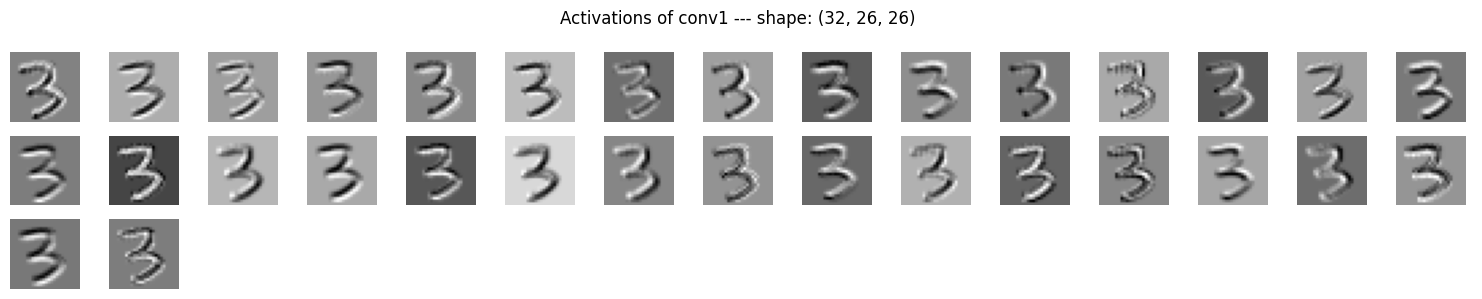

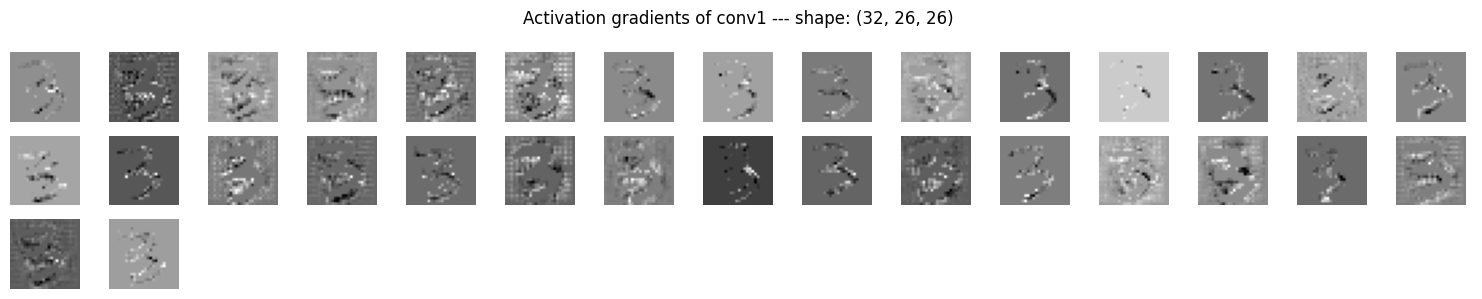

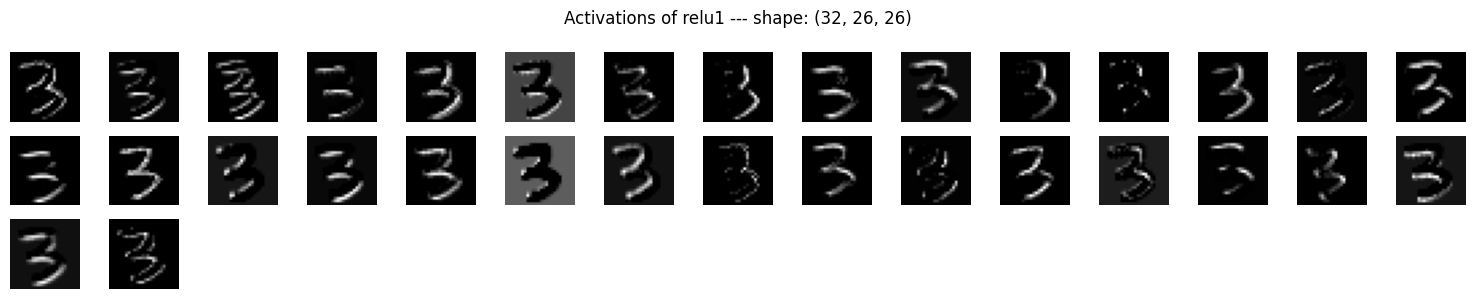

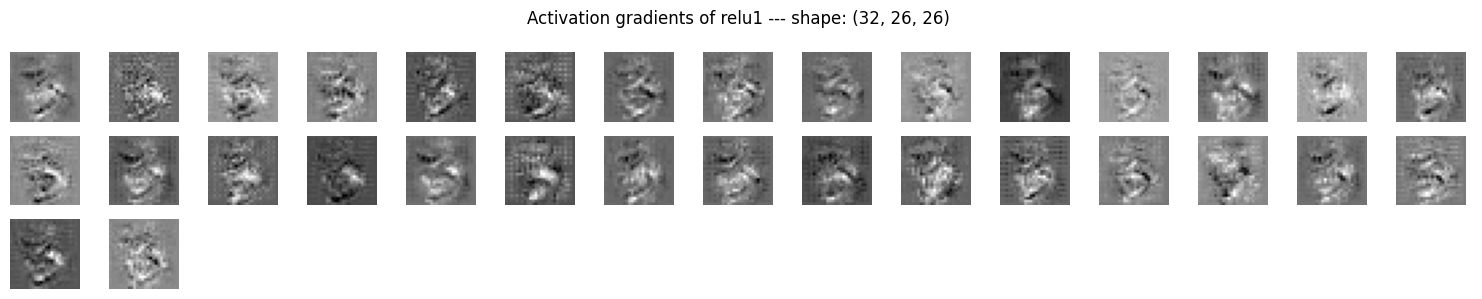

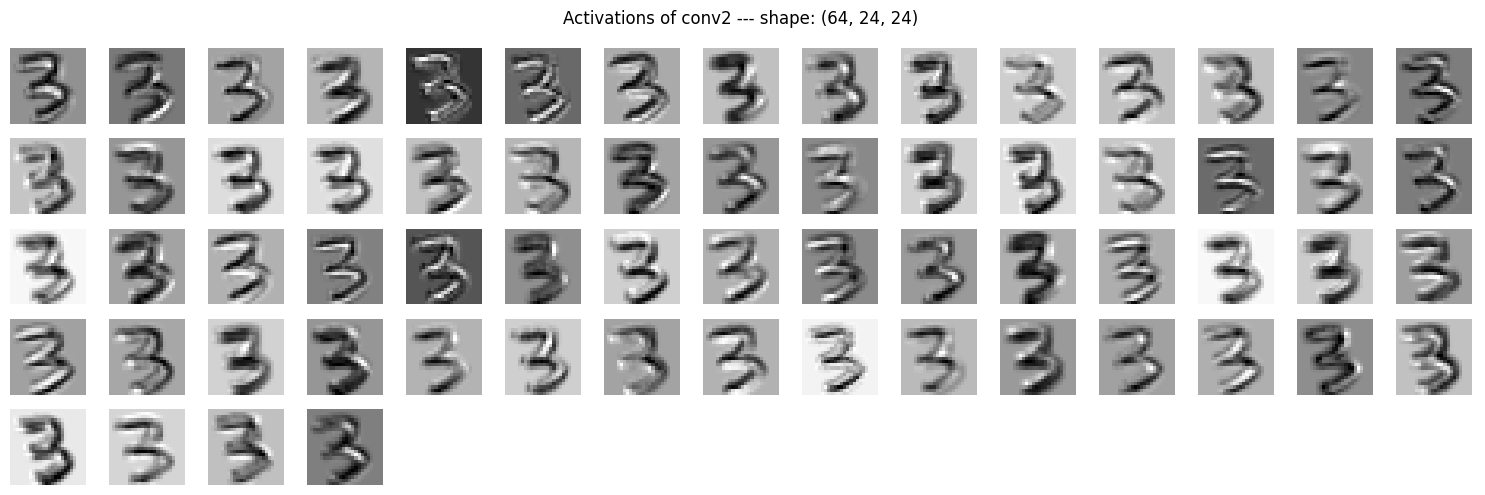

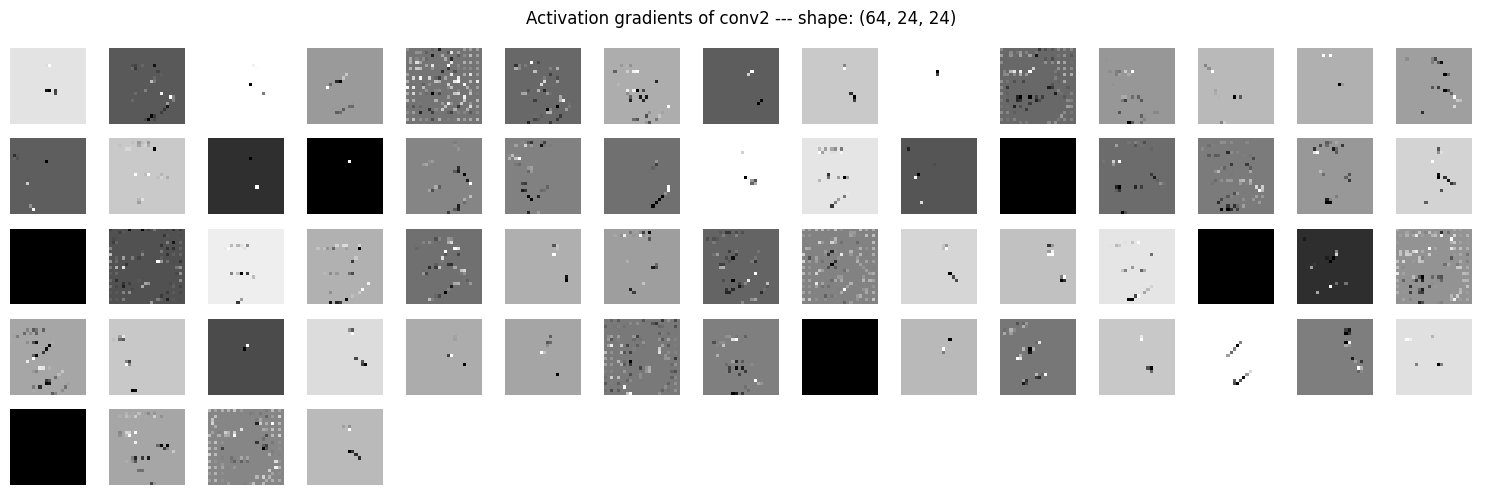

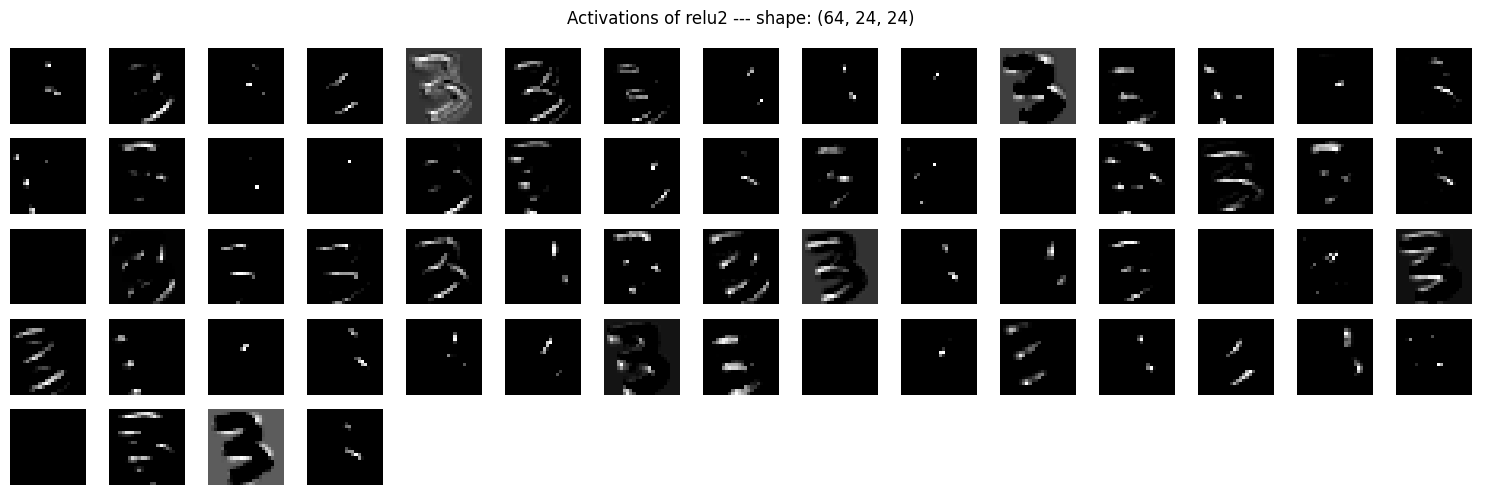

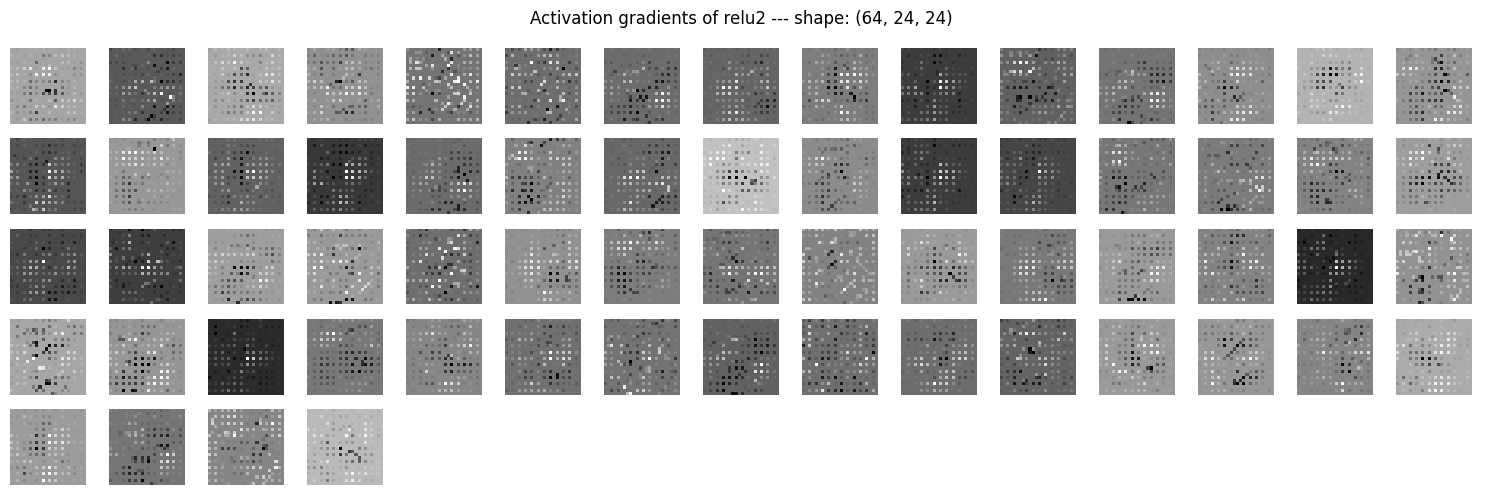

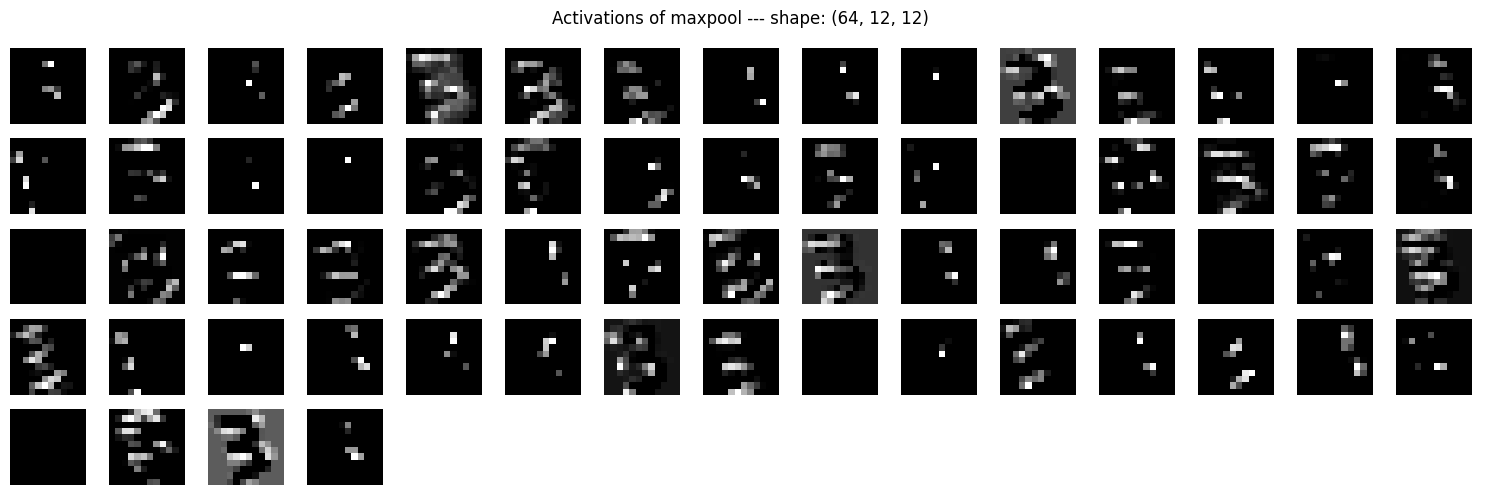

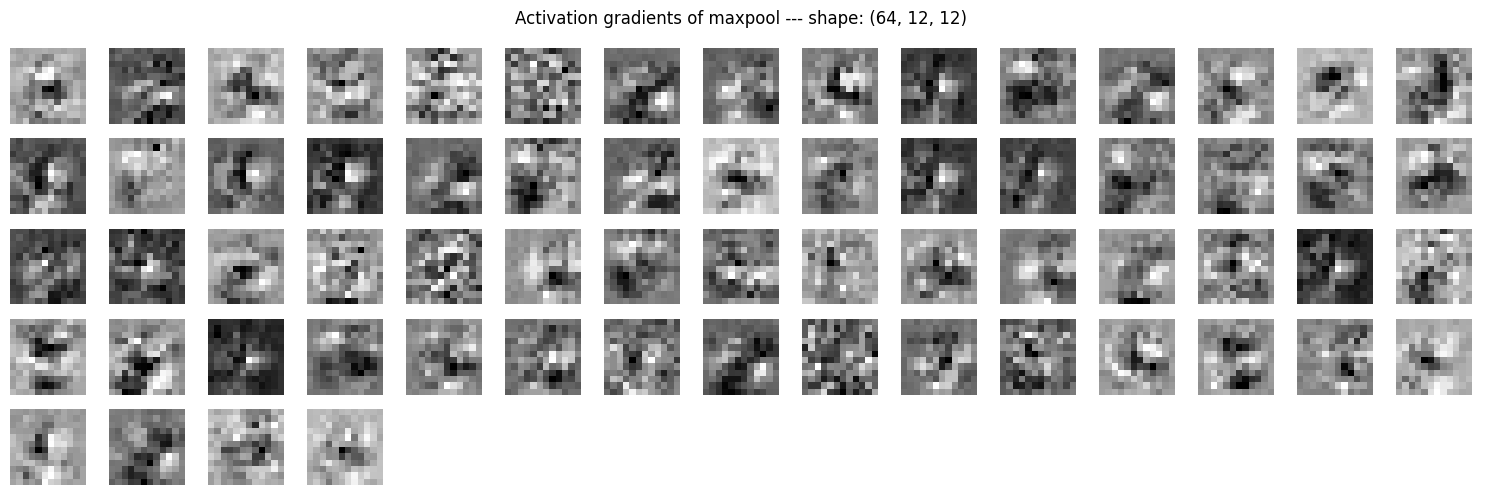

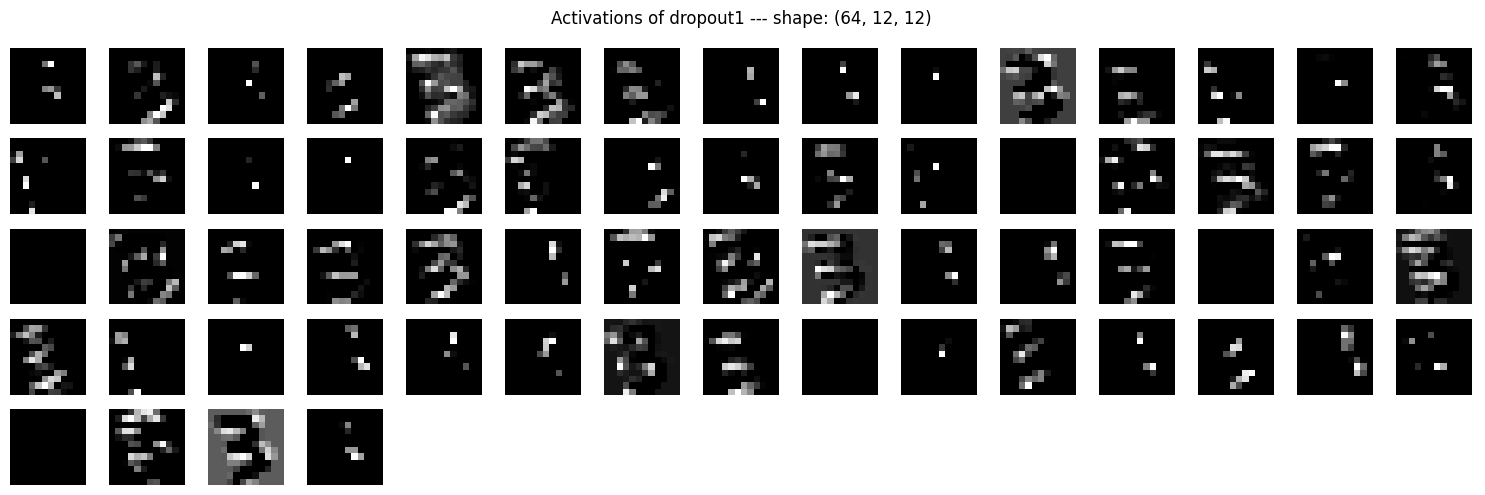

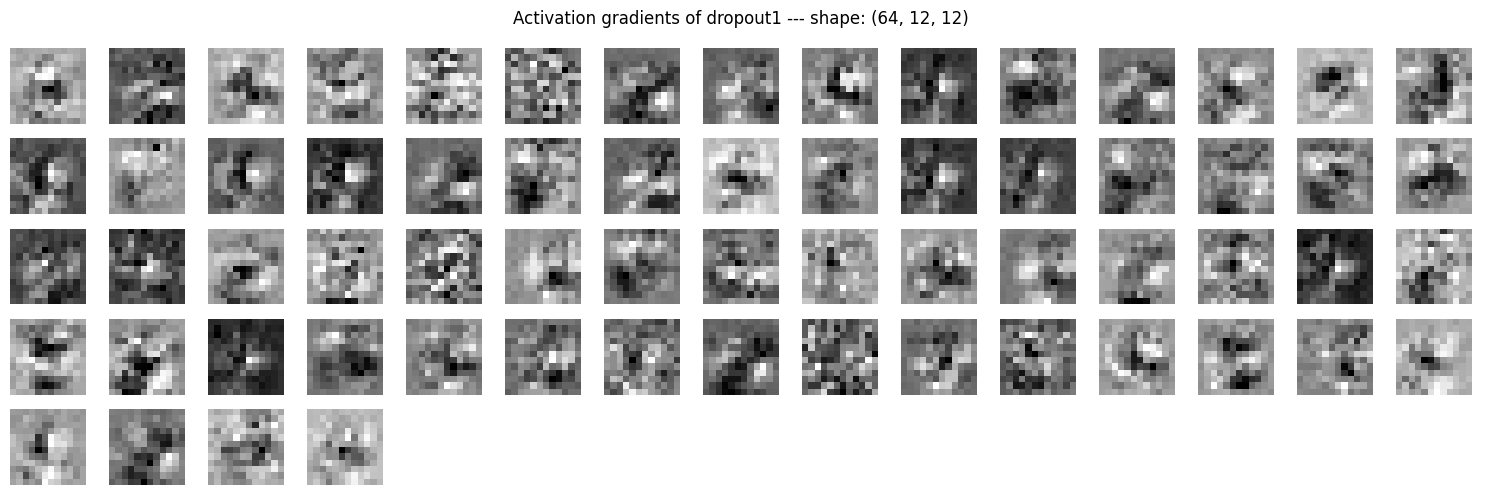

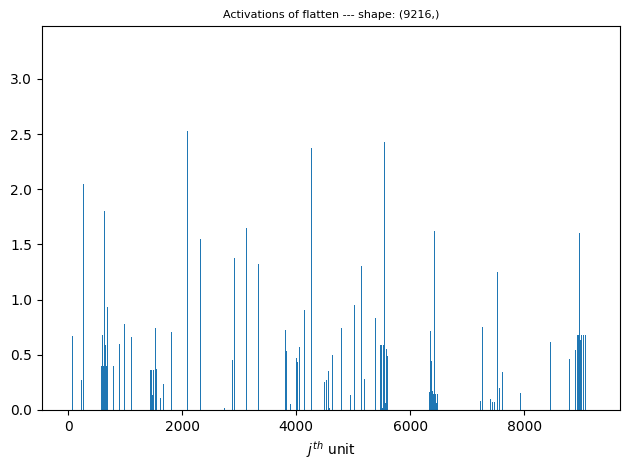

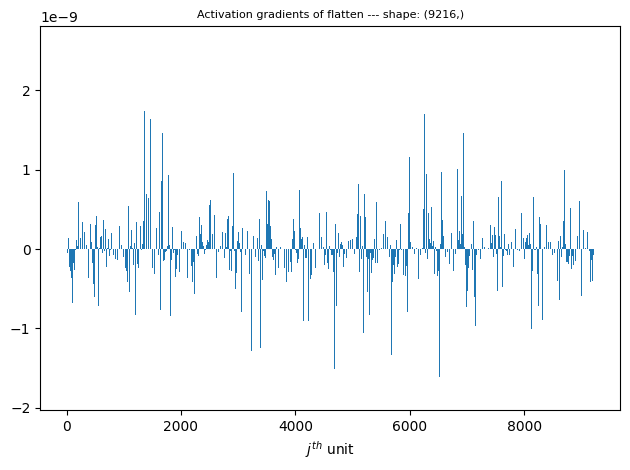

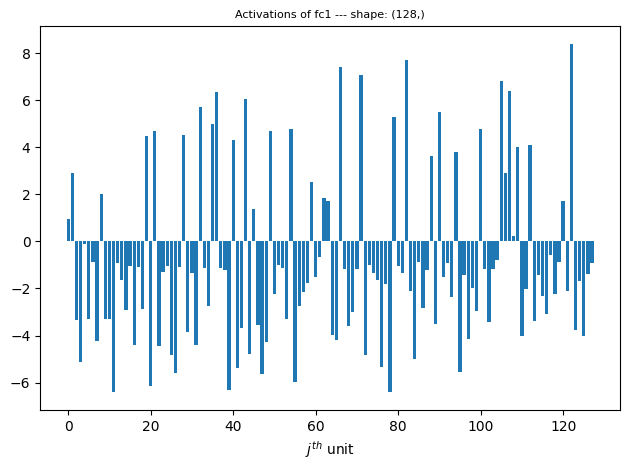

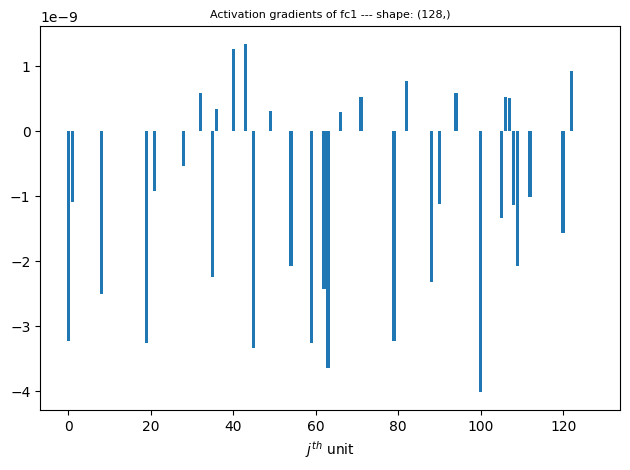

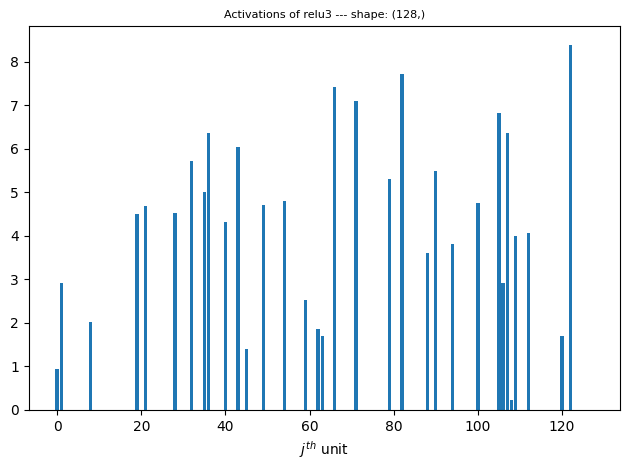

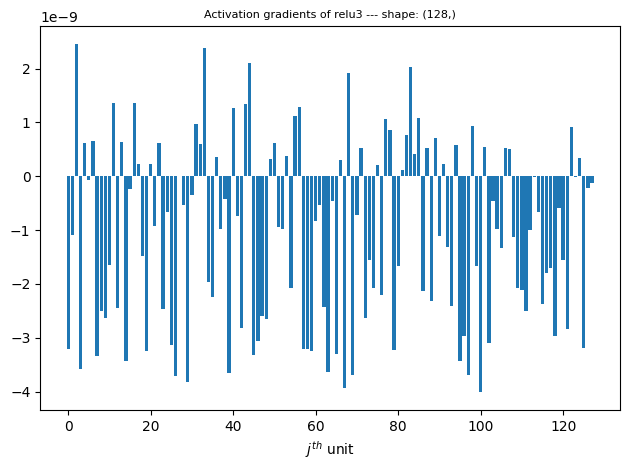

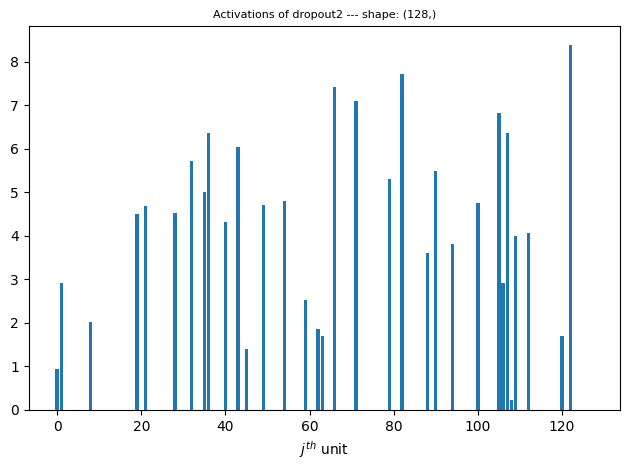

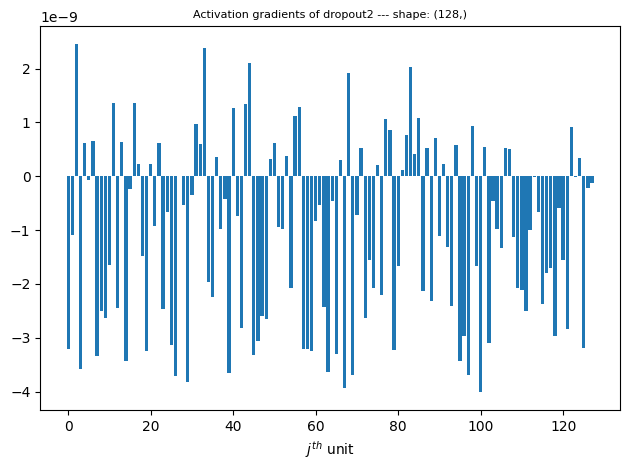

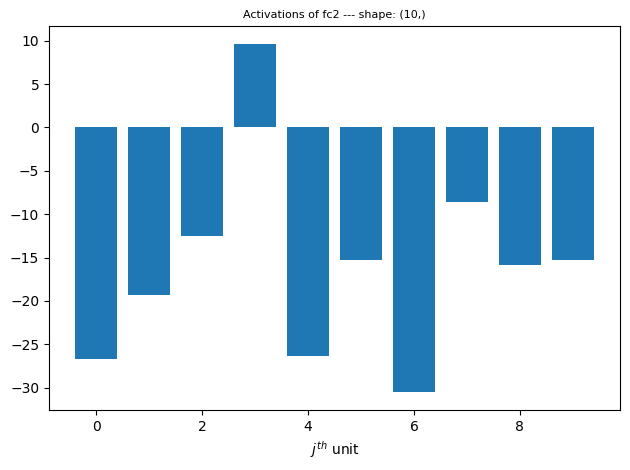

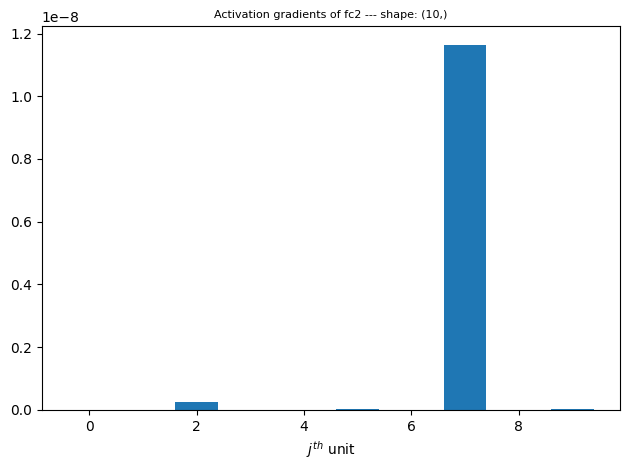

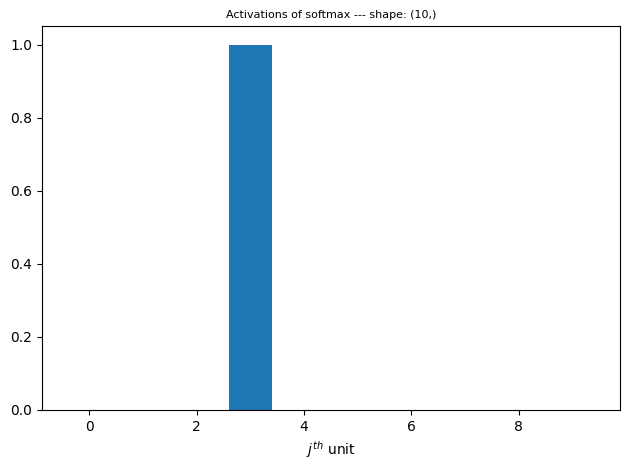

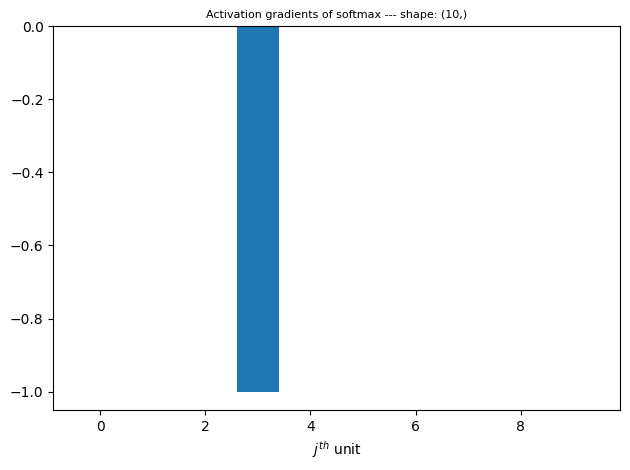

In [99]:
for layer_name in tracked:
    plot_activation(tracked[layer_name]["a"], layer_name, is_grad=False)
    plot_activation(tracked[layer_name]["a_grad"], layer_name, is_grad=True)

In [100]:
print(f'{tracked["conv1"]["w"].shape=}')
print(f'{tracked["conv1"]["b"].shape=}')
print(f'{tracked["conv2"]["w"].shape=}')
print(f'{tracked["conv2"]["b"].shape=}')
print(f'{tracked["fc1"]["w"].shape=}')
print(f'{tracked["fc1"]["b"].shape=}')
print(f'{tracked["fc2"]["w"].shape=}')
print(f'{tracked["fc2"]["b"].shape=}')

tracked["conv1"]["w"].shape=(32, 1, 3, 3)
tracked["conv1"]["b"].shape=(32,)
tracked["conv2"]["w"].shape=(64, 32, 3, 3)
tracked["conv2"]["b"].shape=(64,)
tracked["fc1"]["w"].shape=(128, 9216)
tracked["fc1"]["b"].shape=(128,)
tracked["fc2"]["w"].shape=(10, 128)
tracked["fc2"]["b"].shape=(10,)


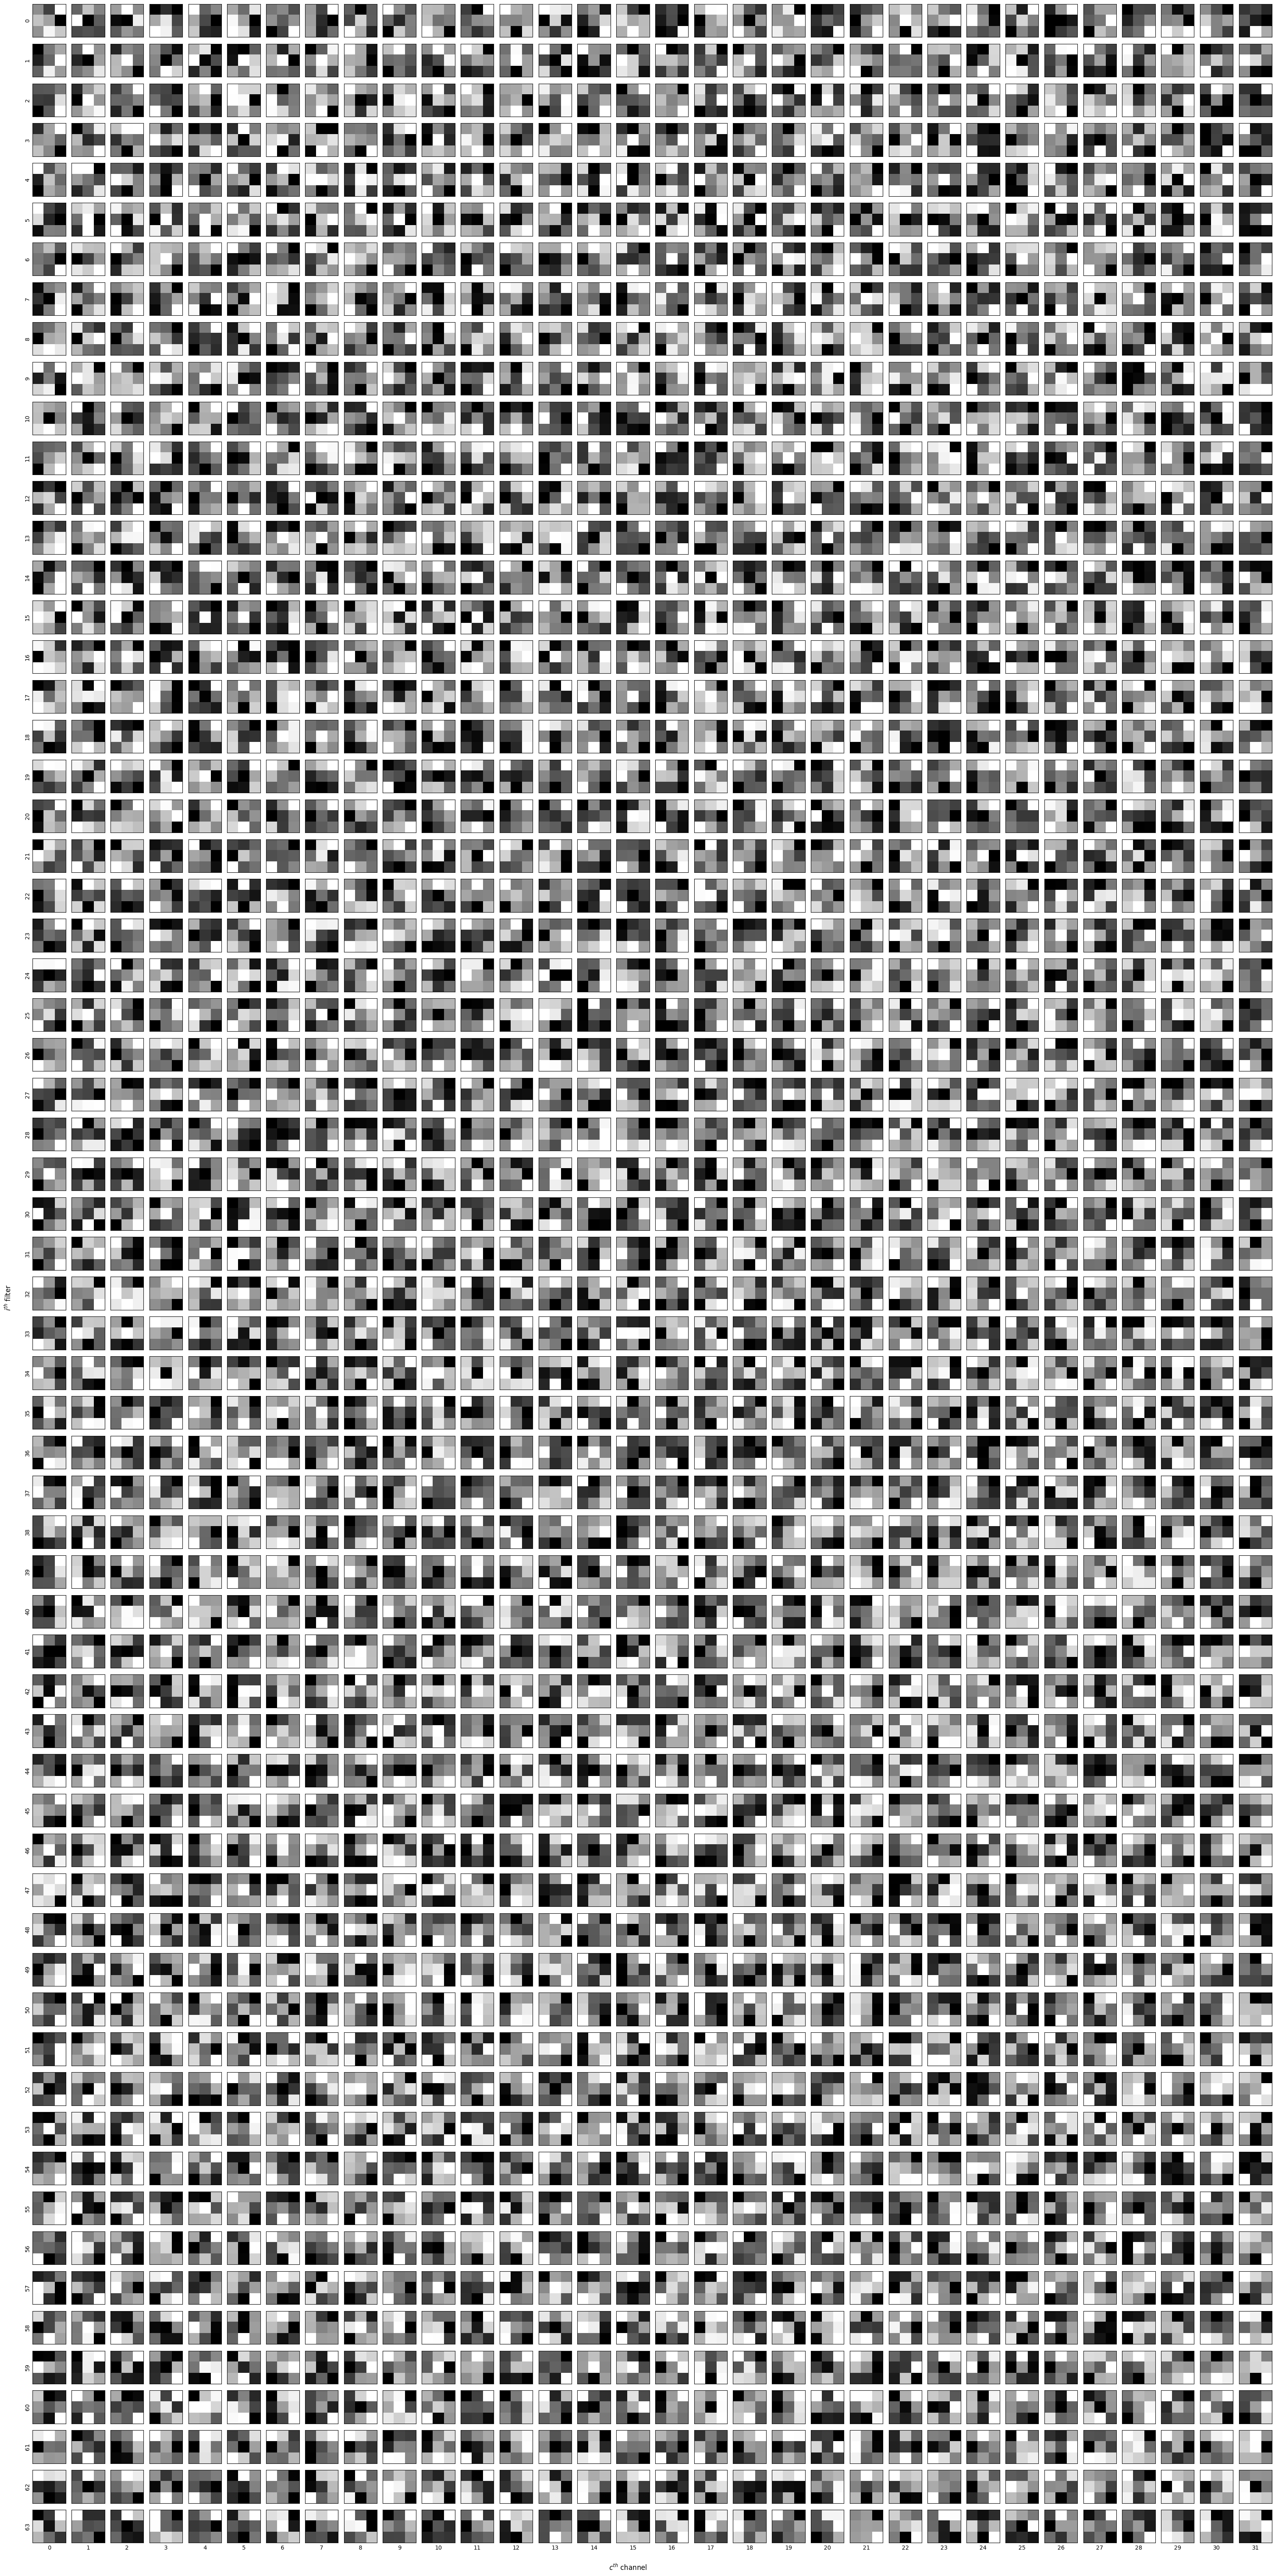

In [101]:
kernels = tracked["conv2"]["w"]
nrows = 64
ncols = 32
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols, nrows))
for i, row_axes in enumerate(axes):
    for j, col_ax in enumerate(np.array(row_axes).reshape(-1)):
        col_ax.imshow(kernels[i, j], cmap="gray")
        if j <= 0:
            col_ax.set_ylabel(str(i))
        if i >= len(axes) - 1:
            col_ax.set_xlabel(str(j))
        col_ax.set_xticks([])
        col_ax.set_yticks([])
fig.supxlabel("$c^{th}$ channel")
fig.supylabel("$i^{th}$ filter")
fig.tight_layout(rect=(0.02, 0.01, 1, 1))
plt.show()

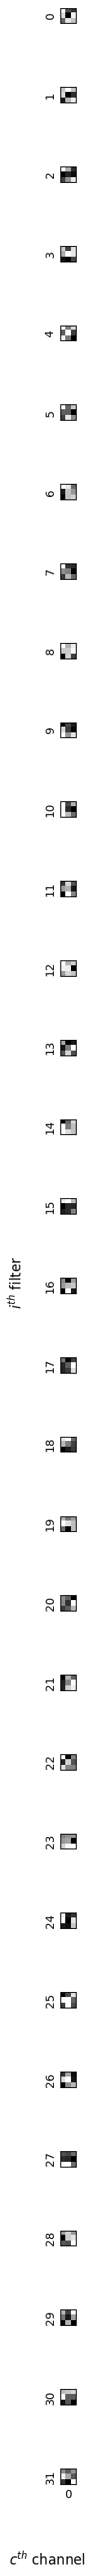

In [102]:
kernels = tracked["conv1"]["w"]
nrows = 32
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols, nrows))
for i, row_axes in enumerate(axes):
    for j, col_ax in enumerate(np.array(row_axes).reshape(-1)):
        col_ax.imshow(kernels[i, j], cmap="gray")
        if j <= 0:
            col_ax.set_ylabel(str(i))
        if i >= len(axes) - 1:
            col_ax.set_xlabel(str(j))
        col_ax.set_xticks([])
        col_ax.set_yticks([])
fig.supxlabel("$c^{th}$ channel")
fig.supylabel("$i^{th}$ filter")
fig.tight_layout(rect=(0.02, 0.01, 1, 1))
plt.show()

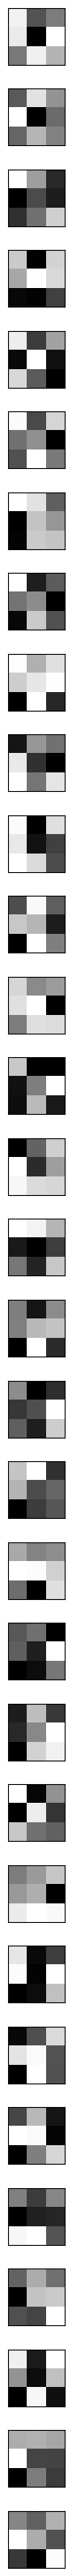

In [76]:
kernels = tracked["conv1"]["w"]
nrows = 32
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols, nrows))
for i, row_axes in enumerate(axes):
    for j, col_ax in enumerate(np.array(row_axes).reshape(-1)):
        col_ax.imshow(kernels[i, j], cmap="gray")
#         if j <= 0:
#             col_ax.set_ylabel(str(i))
#         if i >= len(axes) - 1:
#             col_ax.set_xlabel(str(j))
        col_ax.set_xticks([])
        col_ax.set_yticks([])
# fig.supxlabel("$c^{th}$ channel")
# fig.supylabel("$i^{th}$ filter")
plt.tight_layout()
# fig.tight_layout(rect=(0.02, 0.02, 1, 1))
plt.show()

In [152]:
weights = tracked["fc1"]["w"]
plt.imshow(weights, cmap="gray")
plt.axis("off")

(-0.5, 9215.5, 127.5, -0.5)

In [87]:
weights.shape

(128, 9216)

In [124]:
tracked["conv2"]["w"].shape

(64, 32, 3, 3)

<BarContainer object of 9216 artists>

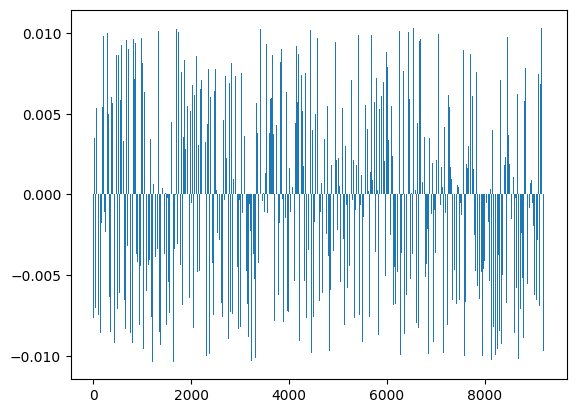

In [138]:
plt.bar(np.arange(len(weights[0])), weights[0])

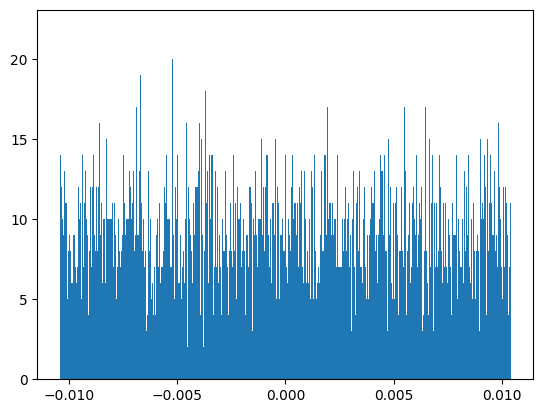

In [147]:
plt.hist(weights[0], bins=1000)
plt.show()

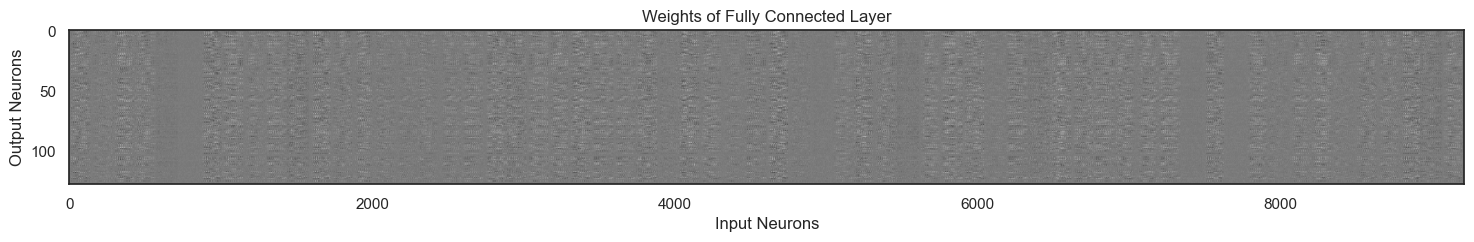

In [180]:
# Generate random weights for demonstration purposes
n_out = weights.shape[0]
n_in = weights.shape[1]
weights = tracked["fc1"]["w"]

fig, ax = plt.subplots(figsize=(18, 2))

# Create the heatmap
ax.imshow(weights, cmap="gray", aspect="auto")

# Set colorbar
# plt.colorbar()

# Set labels and title
plt.xlabel('Input Neurons')
plt.ylabel('Output Neurons')
plt.title('Weights of Fully Connected Layer')
# plt.tight_layout()
# Show the plot
plt.show()


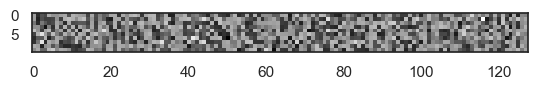

In [179]:
n_out = weights.shape[0]
n_in = weights.shape[1]
weights = tracked["fc2"]["w"]

# Create the heatmap
plt.imshow(weights, cmap="gray")

# Set colorbar
# plt.colorbar()

# Set labels and title
# plt.xlabel('Input Neurons')
# plt.ylabel('Output Neurons')
# plt.title('Weights of Fully Connected Layer')

# Show the plot
plt.show()